In [3]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("notebook")
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**


# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# Read identity of wells and antigen spots

In [13]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=os.path.join(data_folder,'interpolationODs.xlsx') #this is data from SMG interpolation approach

In [5]:
plate_info_df=pd.read_csv(plateinfo_path)
plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)
serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True)
serum_day_df.fillna(0, inplace=True)
serum_day_df.columns=['serum', 'day']
plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
plate_info_df.drop(['Sera ID'], axis=1, inplace=True)
plate_info_df
plate_info_df['serum'].unique()

array(['HumanReferencePlasma', 'anti-HA mAb MEDI8852',
       'antii-HA mAb TF19', 'MS', '005-18', '006', 'AssayDiluentControl',
       'ab115777 RabbitTubulinControl'], dtype=object)

In [6]:
converter = {col: str for col in range(0,7)}
antigen_df = pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter, index_col=0)
antigen_df = antigen_df.unstack().reset_index(name='antigen') # unpivot (linearize) the table
antigen_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
antigen_df

,antigen_row,antigen_col,antigen
0,0,0,xkappa biotin
1,0,1,xkappa biotin
2,0,2,xIgG Fc
3,0,3,xIgG Fc
4,0,4,xIgG Fc
5,0,5,xkappa biotin
6,1,0,Flu vaccine 2018-2019
7,1,1,H1 HA
8,1,2,H3 HA
9,1,3,H7 HA


# Read ODs of all wells

## Read data

In [7]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [8]:
# Read all wells into dictionary and into a 4D numpy array.
OD_df = pd.DataFrame()
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        OD_1_well_df = pd.read_excel(antigenOD_path, sheet_name=well_key, index_col=0)
        OD_1_well_df = OD_1_well_df.unstack().reset_index(name='OD') # unpivot (linearize) the table
        OD_1_well_df.rename(columns={'level_0': 'antigen_row', 'level_1': 'antigen_col'}, inplace=True)
        OD_1_well_df['well_id'] = well_key
        wellID[r,c] = well_key
        OD_df = OD_df.append(OD_1_well_df, ignore_index=True)
OD_df

,antigen_row,antigen_col,OD,well_id
0,0,0,1.365038,A1
1,0,1,1.300022,A1
2,0,2,1.527346,A1
3,0,3,1.383002,A1
4,0,4,1.235165,A1
...,...,...,...,...
3451,5,1,0.998054,H12
3452,5,2,1.019230,H12
3453,5,3,1.020443,H12
3454,5,4,1.021060,H12


# Merge tables into one

In [9]:
OD_df = pd.merge(OD_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
OD_df = pd.merge(OD_df,
                 plate_info_df,
                 how='left', on=['well_id'])

OD_df

,antigen_row,antigen_col,OD,well_id,antigen,type,dilution,serum,day
0,0,0,1.365038,A1,xkappa biotin,Control,1.0,HumanReferencePlasma,0
1,0,1,1.300022,A1,xkappa biotin,Control,1.0,HumanReferencePlasma,0
2,0,2,1.527346,A1,xIgG Fc,Control,1.0,HumanReferencePlasma,0
3,0,3,1.383002,A1,xIgG Fc,Control,1.0,HumanReferencePlasma,0
4,0,4,1.235165,A1,xIgG Fc,Control,1.0,HumanReferencePlasma,0
...,...,...,...,...,...,...,...,...,...
3451,5,1,0.998054,H12,empty,Control,1.0,AssayDiluentControl,0
3452,5,2,1.019230,H12,GFP foldon,Control,1.0,AssayDiluentControl,0
3453,5,3,1.020443,H12,GFP foldon,Control,1.0,AssayDiluentControl,0
3454,5,4,1.021060,H12,GFP foldon,Control,1.0,AssayDiluentControl,0


# Plot standard curves

## Plot antibody response to all antigens from one serum sample

[None]

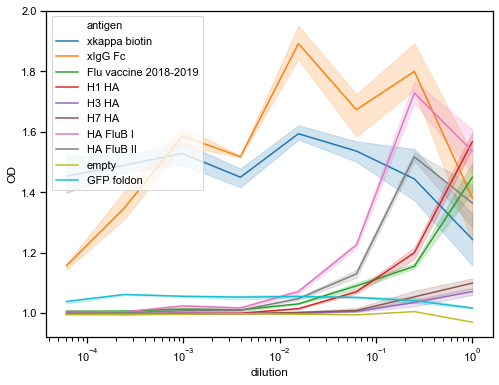

In [10]:
serum = 'HumanReferencePlasma'
sub_df = OD_df[(OD_df['serum']==serum)] 
# ref_plm_df = ref_plm_df.dropna()
plt.figure(figsize =(8, 6))
ax = sns.lineplot(x="dilution", y="OD", hue='antigen', data=sub_df)
ax.set(xscale="log")

## Compare across sera at Day 0

<Figure size 576x432 with 0 Axes>

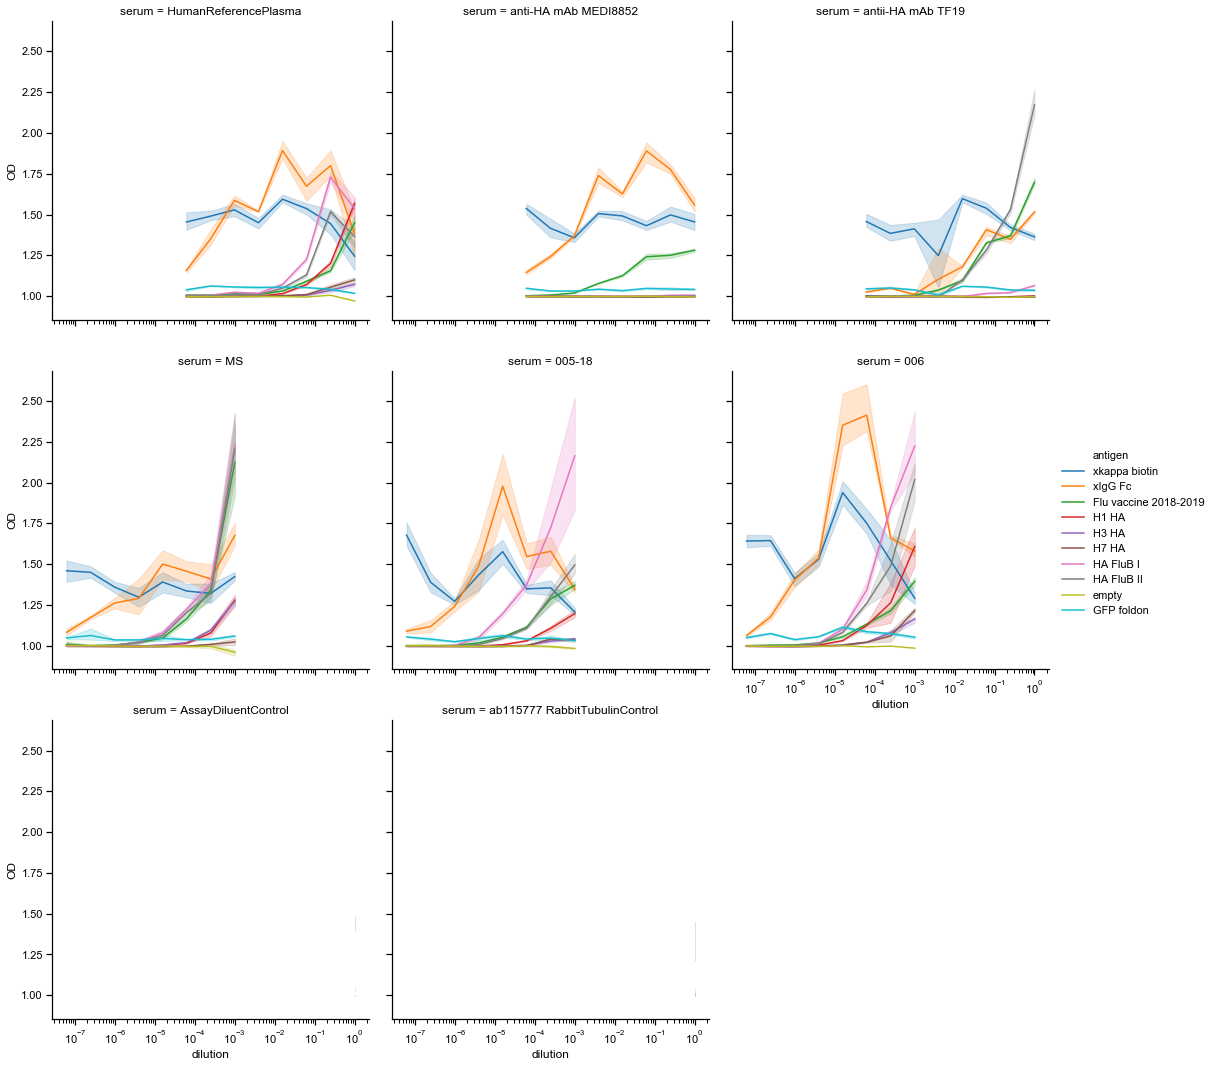

In [11]:
day = 0
ref_plm_df = OD_df[(OD_df['day']==0)] 
plt.figure(figsize =(8, 6))
ax = sns.relplot(x="dilution", y="OD",
                hue="antigen", col="serum",
                kind="line", data=OD_df, col_wrap=3)
ax.set(xscale="log")

## Compare sera for each antigen

<Figure size 432x432 with 0 Axes>

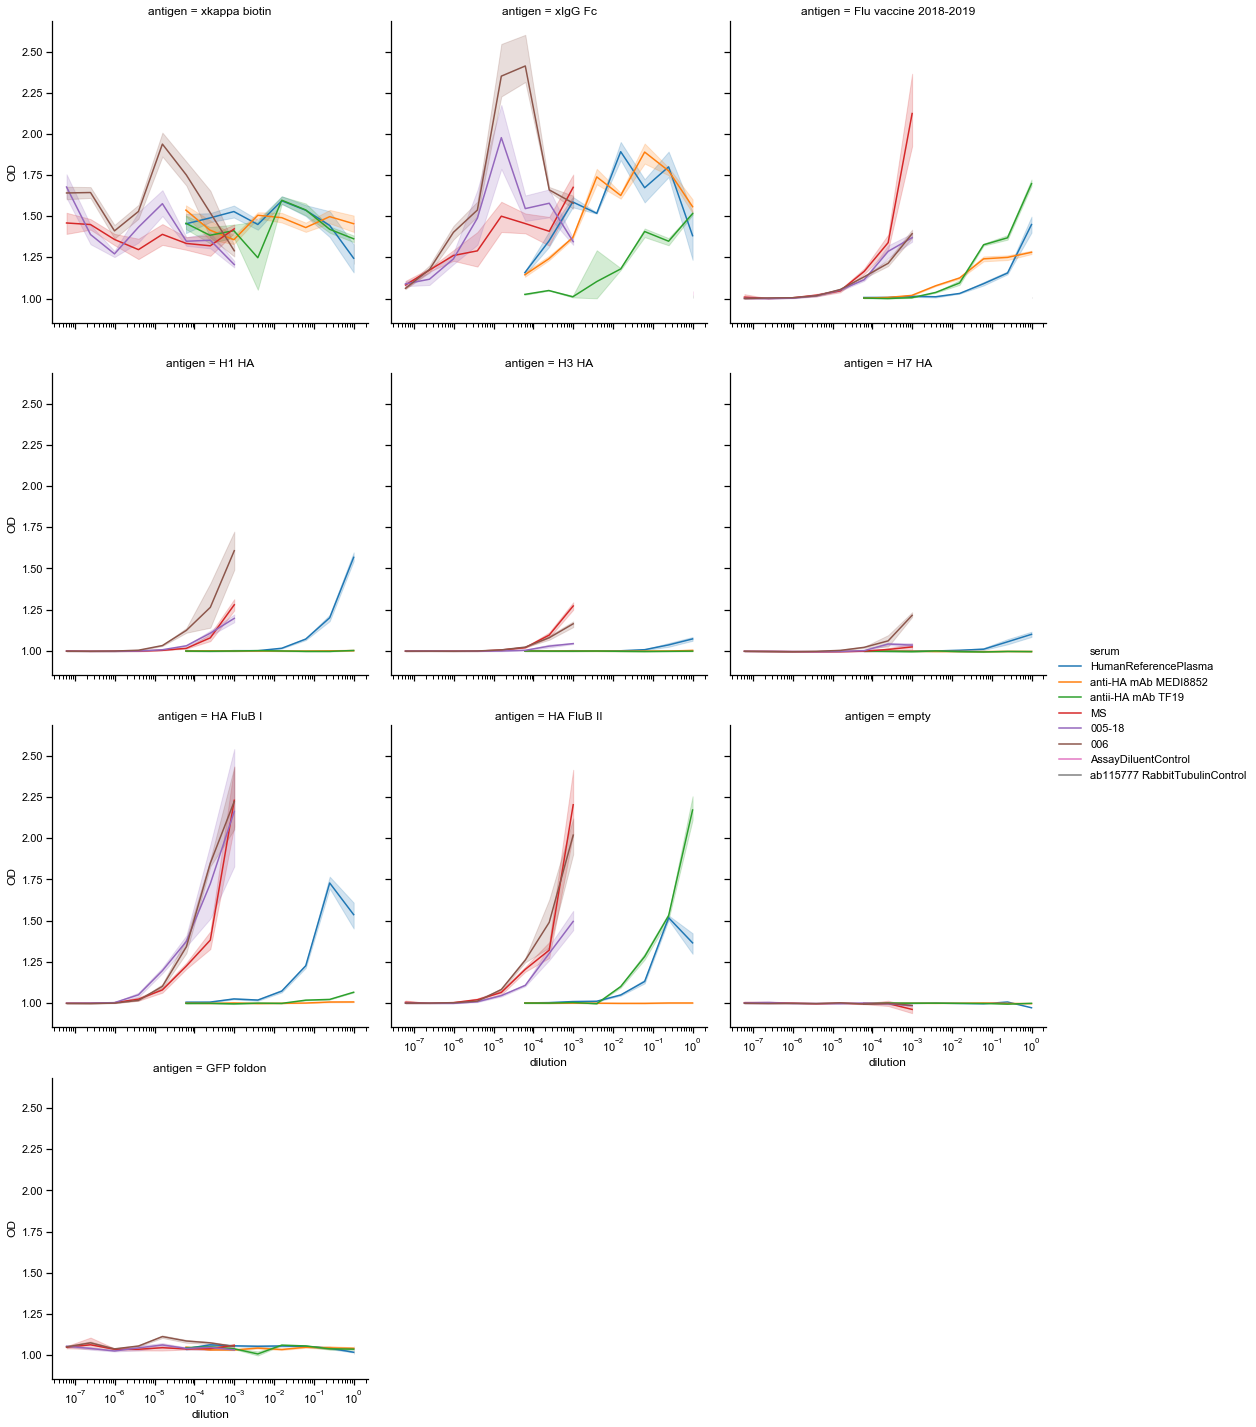

In [12]:
ref_plm_df = OD_df
plt.figure(figsize =(6, 6))
ax = sns.relplot(x="dilution", y="OD",
                hue="serum", col="antigen",
                kind="line", data=OD_df, col_wrap=3)
ax.set(xscale="log")

In [19]:
serum = 'AssayDiluentControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

serum = 'ab115777 RabbitTubulinControl'
sub_df = OD_df[(OD_df['serum']==serum)]
print(sub_df['dilution'].unique())

[1.]
[1.]


# Read identity of wells and antigen spots in 2D arrays if preferred

In [14]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

array([['A1', 'HumanReferencePlasma', 'Control', 1.0],
       ['A2', 'anti-HA mAb MEDI8852', 'Control', 1.0],
       ['A3', 'antii-HA mAb TF19', 'Control', 1.0],
       ['A4', 'MS-Day0', 'Diagnostic', 0.001],
       ['A5', 'MS-Day7', 'Diagnostic', 0.001],
       ['A6', 'MS-Day14', 'Diagnostic', 0.001],
       ['A7', 'MS-Day21', 'Diagnostic', 0.001],
       ['A8', '005-18-Day0', 'Diagnostic', 0.001],
       ['A9', '005-18-Day7', 'Diagnostic', 0.001],
       ['A10', '005-18-Day18', 'Diagnostic', 0.001],
       ['A11', '006-Day7', 'Diagnostic', 0.001],
       ['A12', 'AssayDiluentControl', 'Control', 1.0],
       ['B1', 'HumanReferencePlasma', 'Control', 0.25],
       ['B2', 'anti-HA mAb MEDI8852', 'Control', 0.25],
       ['B3', 'antii-HA mAb TF19', 'Control', 0.25],
       ['B4', 'MS-Day0', 'Diagnostic', 0.00025],
       ['B5', 'MS-Day7', 'Diagnostic', 0.00025],
       ['B6', 'MS-Day14', 'Diagnostic', 0.00025],
       ['B7', 'MS-Day21', 'Diagnostic', 0.00025],
       ['B8', '005-18-Day0

In [15]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

array([['xkappa biotin', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'xkappa biotin'],
       ['xkappa biotin', 'H1 HA', 'H1 HA', 'H1 HA', 'H1 HA', 'empty'],
       ['xIgG Fc', 'H3 HA', 'H3 HA', 'H3 HA', 'H3 HA', 'GFP foldon'],
       ['xIgG Fc', 'H7 HA', 'H7 HA', 'H7 HA', 'H7 HA', 'GFP foldon'],
       ['xIgG Fc', 'HA FluB I', 'HA FluB I', 'HA FluB I', 'HA FluB I',
        'GFP foldon'],
       ['xkappa biotin', 'HA FluB II', 'HA FluB II', 'HA FluB II',
        'HA FluB II', 'xkappa biotin']], dtype=object)


# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [16]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [17]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [18]:
pprint(antigenOD[0,0]) # Well A1

array([[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
        1.3063261 ],
       [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
        0.97001301],
       [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
        1.01487095],
       [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
        1.01577171],
       [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
        1.01984698],
       [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
        1.13418449]])


In [9]:
pprint(antigenOD[0,3]) # well A4

array([[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
        1.08886344, 1.23414691, 1.61283121],
       [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
        1.081295  , 1.06818851, 3.55750328],
       [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
        1.03519571, 1.13637536, 1.10705243],
       [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
        1.04190418, 1.11740187, 1.08562124],
       [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
        1.0787549 , 1.05155942, 1.00879728],
       [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
        1.06769399, 1.05361099, 1.40577401]])


#### logical indexing

In [19]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.51057438, 1.72730503, 1.60149197, 1.63297109, 1.5686067 ,
         1.32212619],
        [1.39139012, 1.19648487, 1.17148837, 1.17381992, 1.1895725 ,
         0.9799163 ],
        [1.55854897, 1.24260422, 1.21974564, 1.20463072, 1.24338333,
         1.04502998],
        [1.56578046, 1.08637737, 1.04226942, 1.03899924, 1.01072581,
         1.05024331],
        [1.57689151, 2.25824464, 1.95320697, 1.86113774, 2.05701918,
         1.04949529],
        [1.46018973, 2.25584258, 1.96541285, 1.9000124 , 2.00442124,
         1.40289936]]])


In [20]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
         1.3063261 ],
        [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
         0.97001301],
        [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
         1.01487095],
        [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
         1.01577171],
        [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
         1.01984698],
        [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
         1.13418449]]])


# Plot standard curve.

In [21]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
#pprint(wellIdx)
#pprint(antigenIdx)

## Find concentrations in control wells

#The control wells in this plate are in columns. A2-H2 is an anti-HA antibody against spots in the top spot row, A3-H3 is an anti-HA antibody against spots in the top spot row and bottom spot row. Column 12 of the plate contains an assay diluent control.

In [26]:
controlWells = []
for row in ['A','B','C','D','E','F','G','H']:
    wellsinthisrow = [row+str(col) for col in range(2,4)]
    controlWells.append(wellsinthisrow)
pprint(controlWells)

[['A2', 'A3'],
 ['B2', 'B3'],
 ['C2', 'C3'],
 ['D2', 'D3'],
 ['E2', 'E3'],
 ['F2', 'F3'],
 ['G2', 'G3'],
 ['H2', 'H3']]


In [32]:
controlWells = np.reshape(controlWells,(16,))
controlConcentrations=np.concatenate([plateInfo[wellIdx == well, wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array([1.0, 1.0, 0.25, 0.25, 0.0625, 0.0625, 0.015625, 0.015625,
       0.00390625, 0.00390625, 0.000976563, 0.000976563,
       0.00024414099999999997, 0.00024414099999999997, 6.1e-05, 6.1e-05],
      dtype=object)


In [33]:

concentrationsAll = np.array([float(strconc) for strconc in controlConcentrations])
concentrations=concentrationsAll[1::2]
pprint(concentrations)

array([1.00000e+00, 2.50000e-01, 6.25000e-02, 1.56250e-02, 3.90625e-03,
       9.76563e-04, 2.44141e-04, 6.10000e-05])


In [30]:
controlWellsMEDI=controlWells[0::2]
pprint(controlWellsMEDI)

array(['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'], dtype='<U2')


## Let's look at mAb MEDI8852 against spot 'Flu vaccine 2018-2019' in the control wells.

In [128]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])
pprint(antigenvaccine)

array([[1.29361701, 1.28230958, 1.26620668, 1.28148715],
       [1.22413749, 1.25108522, 1.26219094, 1.26221479],
       [1.23226354, 1.21985598, 1.24805682, 1.26364718],
       [1.1328589 , 1.12572158, 1.11748446, 1.12382501],
       [1.07654113, 1.07959817, 1.08066351, 1.07320915],
       [1.01554702, 1.02020619, 1.01955793, 1.01968565],
       [1.00726404, 1.00590698, 1.00645212, 1.00599513],
       [1.00224073, 1.00265987, 1.00239297, 1.00151115]])


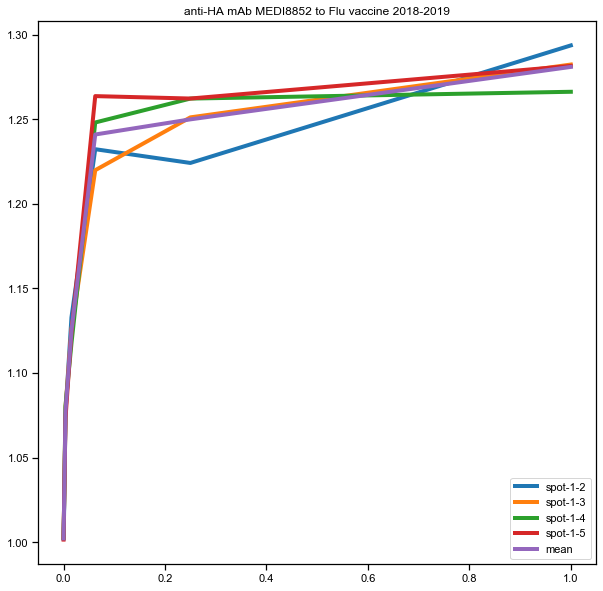

In [36]:
#antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])

#plt.figure(figsize=(10,10))
#plt.plot(concentrations,antigenvaccine,concentrations,np.mean(antigenvaccine,axis=1),lw=4 );
#plt.legend(['spot-1-2','spot-1-3','spot-1-4','spot-1-5','mean'])
#plt.title('anti-HA mAb MEDI8852 to Flu vaccine 2018-2019');


## Fit a 4PL to mean values from anti-HA mAB MEDI8852 to vaccine spots

#To generate a curve, arrange a np array of standard curve concentrations in ascending order, and arrays of ODs from standard curve and unknown samples in increasing concentration (i.e. highest dilution at first element of array)

In [129]:
concentrations2=[300,
75,
18.75,
4.6875,
1.171875,
0.29296875,
0.073242188,
0.018310547]
concentrations2=np.flip(concentrations2)
pprint(concentrations2)

array([1.8310547e-02, 7.3242188e-02, 2.9296875e-01, 1.1718750e+00,
       4.6875000e+00, 1.8750000e+01, 7.5000000e+01, 3.0000000e+02])


In [130]:
flippedmeans=np.flip(np.mean(antigenvaccine,axis=1)) #flip the mean values to be in increasing order

#In the following cell, input xdata as array of concentrations and ydata as array of ODs for standard curve. Adjust labels and title on plot. 

<ipython-input-131-4a0db459b974>:5: RuntimeWarning: invalid value encountered in power
  return ((A-D)/(1.0+((x/C)**(B))) + D)


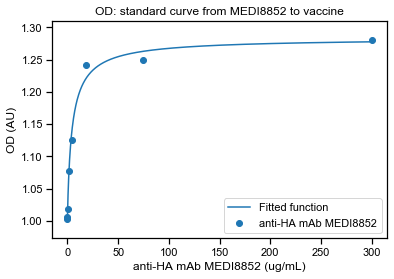

In [131]:
import scipy.optimize as optimization
xdata = concentrations2
ydata = flippedmeans
def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)

guess = [0, -0.5, 0.5, 1]
params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess)#, maxfev=1)

x_min, x_max = np.amin(xdata), np.amax(xdata)
xs = np.linspace(x_min, x_max, 1000)
plt.scatter(xdata, ydata, label='anti-HA mAb MEDI8852')
plt.plot(xs, fourPL(xs, *params), label='Fitted function')
plt.legend(loc='best')
plt.xlabel('anti-HA mAb MEDI8852 (ug/mL)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from MEDI8852 to vaccine');
plt.show()

#The concentration of MEDI8852 starts at 300 ug/mL (or 10x), so we can add that to the plot for interpolation

In [132]:
pprint(params) #These are the parameters for the 4PL

array([1.00088831, 0.90685777, 4.62797342, 1.28376892])


In [133]:
def getConcentration(ODs,params):
    A=[params[0]]
    A=np.asarray(A)
    B=[params[1]]
    B=np.asarray(B)
    C=[params[2]]
    C=np.asarray(C)
    D=[params[3]]
    D=np.asarray(D)
# I think there is an issue with raising negative numbers to a fractional exponent. This needs to be fixed
    #return C*((((A-D)/(ODs-D))-1) **(1/B))
    return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))

In [134]:
test60=np.array([1,0.99,1.632,1.24])
test61=getConcentration(test60,params)
pprint(test61)

array([        nan,         nan,         nan, 30.10002861])


<ipython-input-133-ca68501019d1>:12: RuntimeWarning: invalid value encountered in power
  return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))


In [135]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
H1HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day0])
H3HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day0])
H7HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day0])
HAFluBIIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day0])

# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay0=np.mean(H1HAMSDay0,axis=1)
mH3HAMSDay0=np.mean(H3HAMSDay0,axis=1)
mH7HAMSDay0=np.mean(H7HAMSDay0,axis=1)
mHAFluBIMSDay0=np.mean(HAFluBIMSDay0,axis=1)
mHAFluBIIMSDay0=np.mean(HAFluBIMSDay0,axis=1)

allMeans=[mFluVaccineMSDay0,mH1HAMSDay0, mH3HAMSDay0,mH7HAMSDay0,mHAFluBIMSDay0,mHAFluBIIMSDay0]

allMeans = np.asarray(allMeans)

allConcentrations=getConcentration(allMeans,params)
pprint(allMeans)
pprint(allConcentrations)

array([[1.6325937 , 1.24057201, 1.12274793, 1.04168365, 1.00825405,
        1.0023307 , 0.99973903, 1.03495   ],
       [1.18284141, 1.05365641, 1.01095905, 0.99956109, 0.99464464,
        0.99662646, 0.99682175, 0.99788761],
       [1.22759098, 1.08346679, 1.01743137, 1.00075848, 0.99729104,
        0.99765584, 0.99699758, 0.99808423],
       [1.04459296, 1.00691867, 1.00022285, 0.99342826, 0.99325535,
        0.99510629, 0.9959808 , 0.99560323],
       [2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
        0.99815258, 0.99566044, 0.99736447],
       [2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
        0.99815258, 0.99566044, 0.99736447]])
array([[           nan, 3.06204191e+01, 3.40359700e+00, 6.49534761e-01,
        8.52921127e-02, 1.37992645e-02,            nan, 5.16502649e-01],
       [8.86398656e+00, 9.12289699e-01, 1.21739347e-01,            nan,
                   nan,            nan,            nan,            nan],
       [2.15532111e+01, 1.74199

<ipython-input-133-ca68501019d1>:12: RuntimeWarning: invalid value encountered in power
  return C*(((np.sign(((A-D)/(ODs-D))-1))*(np.abs(((A-D)/(ODs-D))-1)))**(1/B))


## Multiply by dilution factor to get the corrected concentration values

In [114]:
initialConcentration=allConcentrations[:,0] #All antigens at the initial concentration for Day 0 from MS serum
correctedConcentration=initialConcentration*1000 #in ug/mL
pprint(correctedConcentration) #in ug/mL


array([           nan,  8863.98656432, 21553.21107321,   710.20283383,
                  nan,            nan])


In [115]:
correctedConcentrationResult = {'Flu vaccine 2018-2019':[correctedConcentration[0]],'H1 HA':[correctedConcentration[1]], 'H3 HA':[correctedConcentration[2]],'H7 HA':[correctedConcentration[3]] ,'HA FluB I':[correctedConcentration[4]], 'HA FluB II':[correctedConcentration[5]]}
pprint(correctedConcentrationResult)
#df = pd.DataFrame(data=correctedConcentrationResult)

{'Flu vaccine 2018-2019': [nan],
 'H1 HA': [8863.986564317329],
 'H3 HA': [21553.211073212395],
 'H7 HA': [710.2028338295794],
 'HA FluB I': [nan],
 'HA FluB II': [nan]}
